- KEYWORDS: autograd



# Flexible nonlinear models for regression



Today we are going to take a meandering path to using autograd to train a neural network for regression. First let's consider this very general looking nonlinear model that we might fit to data. There are 10 parameters in it, so we should expect we can get it to fit some data pretty well.

$y = b1 + w10 tanh(w00 x + b00) + w11 tanh(w01 x + b01) + w12 tanh(w02 x + b02)$

For now let us not concern ourselves with how we chose this particular model. We will return to the choices later.

We will use it to fit data that is generated from $y = x^\frac{1}{3}$. First, we just do a least\_squares fit. This function is similar to `scipy.optimize.curve_fit`.



In [1]:
import autograd.numpy as np
from autograd import jacobian

from scipy.optimize import least_squares
least_squares?

Here is the data we are going to work with.



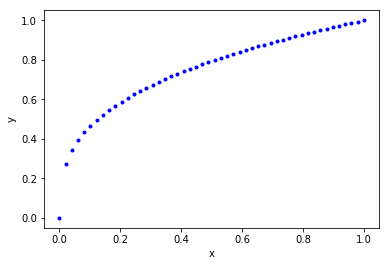

In [1]:
# Some generated data
X = np.linspace(0, 1)
Y = X**(1. / 3.)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(X, Y, 'b.')
plt.xlabel('x')
plt.ylabel('y')

We have to define a function for our model, and then another one for the residuals. For now, we stick with a syntax we are familiar with, and one that works with `least_squares`.



In [1]:
def model(x, *pars):
    b1, w10, w00, b00, w11, w01, b01, w12, w02, b02 = pars
    pred = (b1 + w10 * np.tanh(w00 * x + b00)
               + w11 * np.tanh(w01 * x + b01)
               + w12 * np.tanh(w02 * x + b02))
    return pred


def resid(pars):
    return Y - model(X, *pars)

Finally, we call `least_squares` to get the parameters. We have a nonlinear model, and are using a nonlinear optimizer, so we need an initial guess to get started. Here we use normally distributed random numbers for the guess.



In [1]:
np.random.randn?

In [1]:
pars = least_squares(resid, x0=np.random.randn(10) * 0.1)
pars.message

'The maximum number of function evaluations is exceeded.'

At first, that looks bad, like we did not succeed. The cost function is small though:



In [1]:
pars.cost

1.3704019599783815e-05

Also, it looks like the gradients at the end-point are all close to zero.



In [1]:
np.set_printoptions(precision=3, suppress=True)
pars.grad

array([ 0., -0., -0., -0., -0., -0., -0., -0., -0., -0.])

Finally, we can see that although our model is not positive definite at the endpoint, the non-zero eigenvalues are greater than zero.



In [1]:
from autograd import hessian
def sse(params):
    return np.sum(resid(params)**2)
H = hessian(sse)
np.linalg.eigvals(H(pars.x))

array([ 532.79,   12.37,    0.63,    0.16,    0.02,    0.  ,    0.  ,
          0.  ,    0.  ,    0.  ])

The zeros suggest our model is too complex, that it has more parameters than are required. We leave this point for future consideration. Also note that the Hessian is singular:



In [1]:
np.linalg.det(H(pars.x))

1.6658867697825024e-34

That means we cannot use any method that requires an inverse Hessian to help with the optimization.

Finally, we can graphically show that this model works ok.



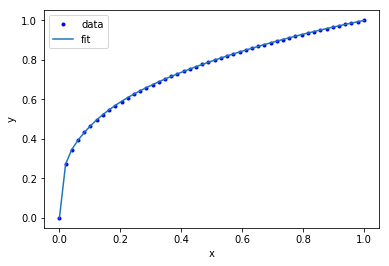

In [1]:
plt.plot(X, Y, 'b.', X, model(X, *pars.x))
plt.legend(['data', 'fit']);
plt.xlabel('x')
plt.ylabel('y')

Evidently, we just have not reached the required tolerances for least\_squares to claim success.

Let's inspect the parameter values. They vary by some orders of magnitude, and surprisingly are all negative.

**Exercise** Run this sequence several times with new initializations. You should get equally good fits, but different parameters. These models are not unique. That is one thing many people do not like about machine learning.



In [1]:
pars.x

array([-103.639,  -20.186,  -54.699,   -2.562,  -38.835,   -5.331,
         -2.94 ,  -45.928,   -0.509,   -2.335])

We have fitted a nonlinear model to the data, and so we should not expect it to extrapolate reliably. We can show this is the case explicitly:



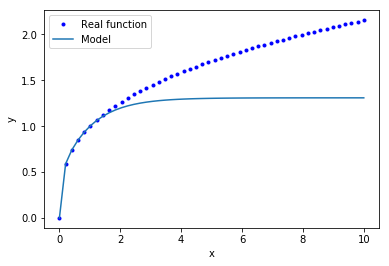

In [1]:
EX = np.linspace(0, 10)
EY = model(EX, *pars.x)
DY = EX**(1 / 3)

plt.plot(EX, DY, 'b.', EX, EY)
plt.legend(['Real function', 'Model'])
plt.xlabel('x')
plt.ylabel('y')

You can see that this model saturates for large $x$. That might be anticipated from knowledge of the tanh function, it also saturates at large values of $x$.



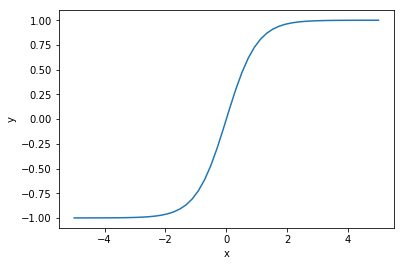

In [1]:
tx = np.linspace(-5, 5)
plt.plot(tx, np.tanh(tx))
plt.xlabel('x')
plt.ylabel('y')

Up to here, this is mostly review for us. It is just a nonlinear regression (admittedly to a strange looking function), and analysis of the resulting model. Note that the model is very flexible, and it can be used to fit a variety of other functions.

I did not pull that model out of nowhere. Let's rewrite it in a few steps. If we think of `tanh` as a function that operates element-wise on a vector, we could write that equation more compactly at:

                                  [w00 * x + b01]
    y = [w10, w11, w12] @ np.tanh([w01 * x + b01]) + b1
                                  [w02 * x + b02]

We can rewrite this one more time in matrix notation:

    y = w1 @ np.tanh(w0 @ x + b0) + b1

Another way to read these equations is that we have an input of $x$. We multiply the input by a vector weights ($\mathbf{w0}$), add a vector of offsets (biases), $\mathbf{b0}$, *activate* that by the nonlinear `tanh` function, then multiply that by a new set of weights, and add a final bias. We typically call this kind of model a *neural network*. There is an input layer, one hidden layer with 3 neurons that are activated by `tanh`, and one output layer with linear activation.

A conventional graphical representation of this function as a neural network is shown here:
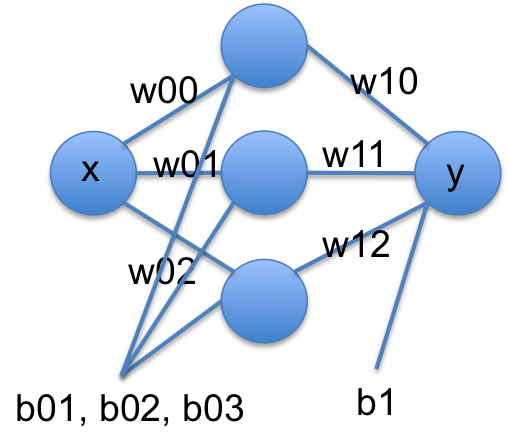

These models are called neural networks because they were originally modeled after neurons. Neurons take input, and if the input is large enough the neuron is activated and has an output. The `tanh` function approximates this behavior in a smooth, differentiable way. Remarkably, neural networks have been shown to be universal function approximators and hence they are extremely useful.

When you use a neural network, you have several choices to make:

1.  How many layers? Here we used one layer, but it is possible to have many layers where the output of the first layer goes to the second layer, etc.  This increases the flexibility of the network.
2.  How many neurons should be in each layer? The more neurons you use, the more parameters there will be. This increases the flexibility of the network.
3.  What activation function to use. The classics are tanh and sigmoid functions, but almost any nonlinear function can be used.

In machine learning lingo, these choices are called *hyperparameters*. These are parameters that determine the size of the model, but they are fixed, and not fitted as part of the model. It is mostly *art and experience* that is how these choices are made. There are many advanced methods for doing this more systematically, but they are computationally expensive and beyond the scope of this class.




# Modern machine learning with neural networks



Modern machine learning does not use the algorithms described above to fit neural networks. Most use a gradient descent based algorithm, which means we need easy access to gradient functions. The standard approaches use automatic differentiation to get these. Autograd was designed in part for building neural networks. Now we will  reformulate this regression as a neural network. This code is lightly adapted from [https://github.com/HIPS/autograd/blob/master/examples/neural_net_regression.py](https://github.com/HIPS/autograd/blob/master/examples/neural_net_regression.py).

First we define a neural network function. This code is more general than what we described before, and can accommodate multiple layers.



In [1]:
def nn(params, inputs, activation=np.tanh):
    """a neural network.
    params is a list of (weights, bias) for each layer.
    inputs goes into the nn. Each row corresponds to one output label.
    activation is the nonlinear activation function.
    """
    for W, b in params[:-1]:
        outputs = np.dot(inputs, W) + b
        inputs = activation(outputs)
    # no activation on the last layer
    W, b = params[-1]
    return np.dot(inputs, W) + b

The next function initializes the weights and biases for each layer in our network. It is standard practice to initialize them to small random numbers to avoid any unintentional symmetries that might occur from a systematic initialization (e.g. all ones or zeros). This code is kind of tricky, but it is very convenient. The size of the arrays are computable. For example, we have one input into a 3 neuron layer, which requires an array of three weights and three biases. Then these get combined back into one output, so we need  again three weights, but now only one bias. In a matrix multiply sense we have: (N, 1) @ (1, 3) @ (3, 1) = (N, 1). This function just automates building this even when there are multiple layers, inputs and outputs.



In [1]:
import autograd.numpy.random as npr

def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples, one for each layer."""
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

To use this, we specify the layer\_sizes, e.g. layer\_sizes=[1, 3, 1] which means one input, 3 neurons in the first layer, and one output.



In [1]:
params = init_random_params(0.1, layer_sizes=[1, 3, 1])
for i, wb in enumerate(params):
    W, b = wb
    print('w{0}: {1}, b{0}: {2}'.format(i, W.shape, b.shape))

print(params)

w0: (1, 3), b0: (3,)
w1: (3, 1), b1: (1,)
[(array([[ 0.073,  0.013,  0.114]]), array([-0.123,  0.04 , -0.068])), (array([[-0.087],
       [-0.058],
       [-0.031]]), array([ 0.006]))]

You can see w0 is a column vector of weights, and there are three biases in b0. W1 in contrast, is a row vector of weights, with one bias. So 10 parameters in total, like we had before. We will create an objective function of the mean squared error again. There is a subtle point here too. The input data will go in with a specific shape of (N, 1) where N is the number of x-points. Our input is from `np.linspace` as a 1D array. So, we build a 2D array with the 1D array as the first row, and then transpose it to get it into a column.

Another subtle detail is the objective function has an optional step argument. We will see shortly this is a required argument for the optimizer algorithm.



In [1]:
def objective(params, step=None):
    pred = nn(params, np.array([X]).T)
    err = np.array([Y]).T - pred
    return np.mean(err**2)

Finally, we are ready to do some optimization. We use the [Adam optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/). The details are not super important at this point, suffice to say it is a gradient descent algorithm. We use `autograd.grad` to provide that gradient of the objective function. One more important point here is the `step_size` argument. This is sometimes also called the *learning rate* in ML jargon. This parameter determines how fast the optimization converges. If it is too small, the rate of convergence is slow. If it is too large, then the convergence may not be stable. This is another *hyperparameter* that affects the model.

We do the training iteratively, taking N steps per iteration. If you run this set of blocks many times, you will get different results from different random initial guesses. Sometimes, the optimization can get trapped in local minima. It takes experience to recognize and diagnose problems with these.



In [1]:
from autograd.misc.optimizers import adam
from autograd import grad

N = 50
MAX_EPOCHS = 500

for i in range(MAX_EPOCHS):
    params = adam(grad(objective), params,
                  step_size=0.01, num_iters=N)
    if i % 100 == 0:  # print every 100th step
        print(f'Step {i}: {objective(params)}')
    if objective(params, _) < 2e-5:
        print('Tolerance reached, stopping')
        break

Step 0: 0.025343421555151416
Step 100: 3.768603309323637e-05
Tolerance reached, stopping

Now we can compare the output of this to our previous fit.



In [1]:
for i, wb in enumerate(params):
    W, b = wb
    print('w{0}: {1}, b{0}: {2}'.format(i, W, b))
print(pars.x)  # from least_squares

w0: [[-32.77   -3.274  -0.914]], b0: [-0.567 -0.129  0.438]
w1: [[-0.664]
 [-0.342]
 [-0.435]], b1: [-0.2]
[-103.639  -20.186  -54.699   -2.562  -38.835   -5.331   -2.94   -45.928
   -0.509   -2.335]

A crucial point is they don't appear related at all. They aren't. There are many sets of parameters that lead to similar fits. These parameters don't have any particular meaning. This is another thing some researchers do not like about neural networks. They are not interpretable as physical parameters.

As before, this model cannot extrapolate (or generalize as ML researchers say).



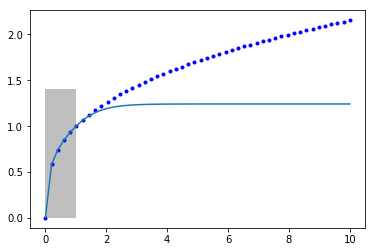

In [1]:
X2 = np.linspace(0, 10)
Y2 = X2**(1/3)
Z2 = nn(params, X2.reshape([-1, 1]))

plt.plot(X2, Y2, 'b.', label='analytical')
plt.plot(X2, Z2, label='NN')
plt.fill_between(X2 < 1, 0, 1.4, facecolor='gray', alpha=0.5)


# Summary



Today we pulled together many ideas about nonlinear models, regression, and optimization as an introduction to modern machine learning. ML is little more than building computational models from data. It is usually using flexible, universal function approximators, e.g. neural networks, and all modern ML relies on automatic differentiation to do the regression.

ML code is much more verbose than the simpler regression models we used previously. There is often data scaling that is done in advance, and *regularization* that is used to reduce overfitting. There are whole courses and now degrees on these topics. You are now at a starting point to study these topics.

